# Model Hubbarda

In [1]:
using LinearAlgebra
using PlotlyJS

include("hubbard_core.jl")

no_particles_from_state (generic function with 1 method)

In [26]:
t = 1
U = 1

dim_sizes = (2)
N = reduce(*, dim_sizes)
# states_1d(n) = reshape(Iterators.product([[0,1] for _ in 1:2n]...) .|> collect, (1, 4^n))
# my_states = states_1d(N)
next(n) = [collect(2:n); 1]
params = Params(dim_sizes, 
    [next(d) for d in dim_sizes]) 

Params(2, fill([2, 1]))

In [7]:
eigen(get_hamiltonian(params, U, t, 0))

ErrorException: eigen(A) not supported for sparse matrices. Use for example eigs(A) from the Arpack package instead.

## Zależność od potencjału chemicznego w T=0K

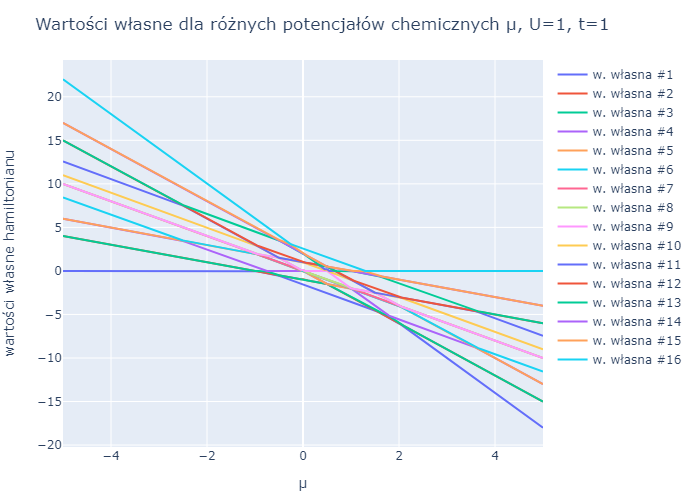

In [27]:
pot_max = 5
pot_step = 0.05
potentials = collect(-pot_max:pot_step:pot_max)
hamiltonian = zeros(4^N, 4^N)

data = [eigen(get_hamiltonian(hamiltonian, params, U, t, pot)) for pot in potentials]
eigs_mat_orig = reduce(hcat,[real(d.values) for d in data])'
eigvecs = [real(d.vectors) for d in data]
eigs_mat = [eigs_mat_orig[:,i] for i in 1:size(eigs_mat_orig,2)]
layout = Layout(
    title="Wartości własne dla różnych potencjałów chemicznych μ, U=$U, t=$t",
    xaxis_title="μ",
    yaxis_title="wartości własne hamiltonianu",
)
pl = plot([scatter(x=potentials, y=eig, name="w. własna #$no") for (eig, no) in zip(eigs_mat, 1:(2N)^2)], layout)

In [30]:
[real(d.vectors)[:,1] for d in data][189]

16-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0

Wybieramy stany o najmniejszej energii (dolna krawędź powyższego wykresu):

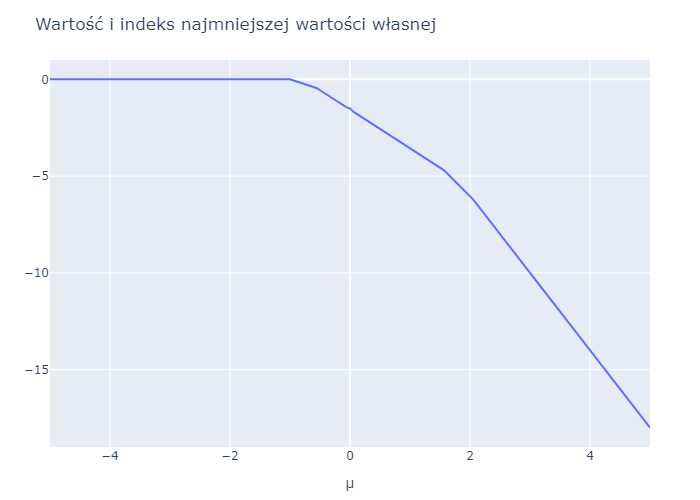

In [4]:
ground_energies = [findmin(eigs_mat_orig[i,:]) for i in 1:size(potentials,1)]
ground_energies = [g[1] for g in ground_energies]
# all_states = [real(eigvecs(get_hamiltonian(states, U, t, pot, next, N))) for pot in potentials]
ground_states = [real(d.vectors)[:,1] for d in data][1]

layout = Layout(
    title="Wartość i indeks najmniejszej wartości własnej",
    xaxis_title="μ",
)
plot(scatter(x=potentials, y=[g for g in ground_energies], name="Wartość"), layout)

Wartości własne zwizualizowane:

In [5]:
# plot([scatter(x=1:16, y=real(data[1].vectors)[1,i]) for i in 1:16])
# plot([scatter(x=1:16, y=real(eigvecs)[1,i]) for i in 1:16])
eigval_idx = 1
eigenvals_sorted = [[eigvecs[pot][:,eigval_idx][eigv] for pot in 1:201] for eigv in 1:16]
plot([scatter(x=potentials, y=tt, name=reduce(*, string.(statename))) for (tt, statename) in zip(eigenvals_sorted, states)])


UndefVarError: UndefVarError: states not defined

Średnia ilość cząstek w stanie, w zależności od potencjału chemicznego:

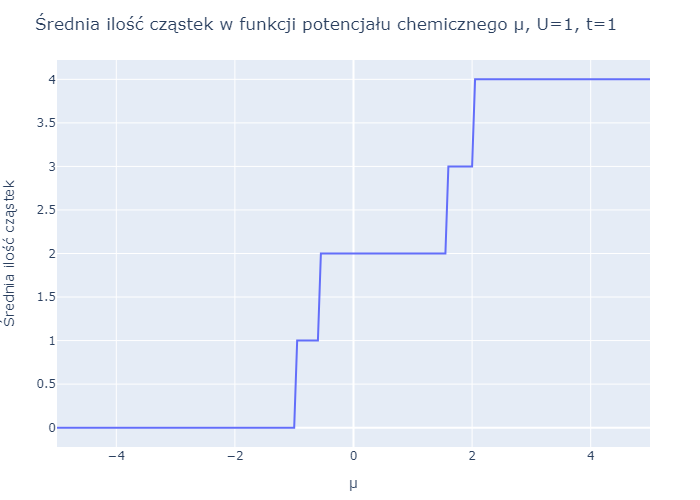

In [6]:
multiplier = [reduce(+, digits(n, base=2)) for n in 0:(4^N -1)]
avg_no_particles = [[no_particles_from_state(state, multiplier) for state in 
    [states_row[:, i] for states_row in eigvecs]] for i in 1:2^(2N)]

layout = Layout(
    title="Średnia ilość cząstek w funkcji potencjału chemicznego μ, U=$U, t=$t",
    xaxis_title="μ",
    yaxis_title="Średnia ilość cząstek",
)
plot([scatter(x=potentials, y=avg_no_particles[1])], layout)

## Zależność temperaturowa

In [6]:
U = 1.0
t = 1.0
k = 1.0

dim_sizes = (2,3)
next(n) = [collect(2:n); 1]
params = Params(dim_sizes, 
    [next(d) for d in dim_sizes]) 

Params((2, 3), [[2, 1], [2, 3, 1]])

In [7]:
function compute_thermodynamic_quantities(params, chem_pot, temperature, U, t, avg_no_multiplier)
    N = reduce(*, params.dim_sizes)
    hamiltonian = zeros(4^N, 4^N)
    H_matrix = get_hamiltonian(hamiltonian, params, U, t, chem_pot)
    diagonalized = eigen(H_matrix)
    energies = diagonalized.values
    H_states = Vector{Float64}[eachcol(diagonalized.vectors)...]
    exp_vec = exp.(-real(energies) / (k*temperature))
    stat_sum = reduce(+, exp_vec)
    avg_particles = [no_particles_from_state(H_state, avg_no_multiplier) for H_state in H_states]
    
    densities = exp_vec ./ stat_sum
    avg_particles_temp = reduce(+, densities .* avg_particles)
    entropy = -k * reduce(+, [abs(p)*log(abs(p)) for p in densities])
    grand_potential = -k*temperature*log(stat_sum)
    return densities, avg_particles_temp, entropy, grand_potential
end

N = reduce(*, params.dim_sizes)
multiplier = [reduce(+, digits(n, base=2)) for n in 0:(4^N -1)]
chem_potentials = -7.5:0.1:7.5
temp_range = round.(10.0.^(range(-1.5,stop=1.5,length=3)), digits=3)

thermodynamics = [[compute_thermodynamic_quantities(params, chem_pot, temperature, U, t, multiplier)
        for chem_pot in chem_potentials] for temperature in temp_range]

avg_n = [[thermodynamics[j][i][2] for i in eachindex(chem_potentials)] for j in eachindex(temp_range)]
entropy_vals = [[thermodynamics[j][i][3] for i in eachindex(chem_potentials)] for j in eachindex(temp_range)]
grand_pots = [[thermodynamics[j][i][4] for i in eachindex(chem_potentials)] for j in eachindex(temp_range)]

helmholtz_vals = [[grand_pot + chem_pot*avg_no for (grand_pot, chem_pot, avg_no) in zip(grand_pot_rows, chem_potentials, avg_no_rows)] 
    for (grand_pot_rows, temp, avg_no_rows) in zip(grand_pots, temp_range, avg_n)]

U_vals = [[helm + entr*temp for (pot, helm, entr) in zip(chem_potentials, helmholtz_vals_rows, entr_rows)]
        for (temp, helmholtz_vals_rows, entr_rows) in zip(temp_range, helmholtz_vals, entropy_vals)]

Średnia ilość cząstek:

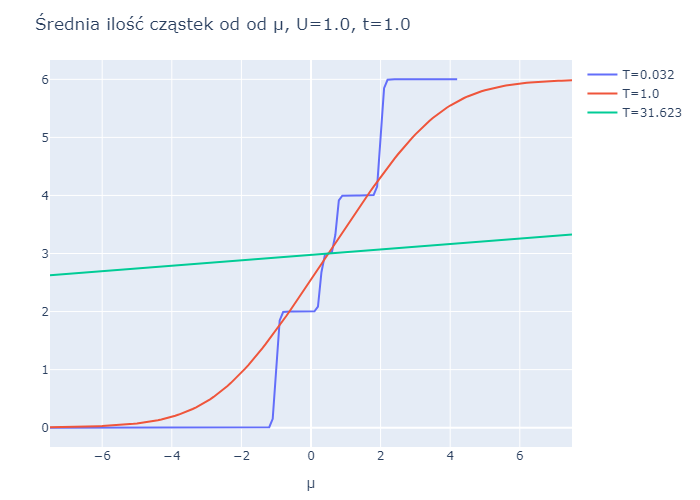

In [4]:
y_vals = real.(avg_n)

layout = Layout(
    title="Średnia ilość cząstek od od μ, U=$U, t=$t",
    xaxis_title="μ",
    yaxis_title="",
)
p = plot([scatter(x=chem_potentials, y=yval, name="T=$t") for (yval, t) in zip(y_vals, temp_range)], layout)

Entropia:

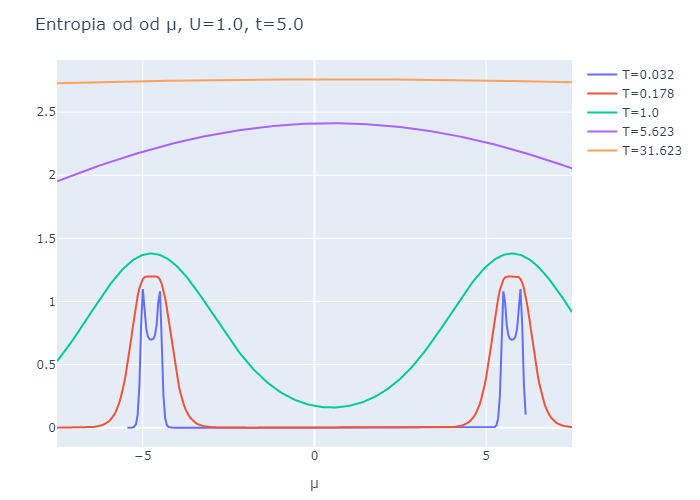

In [21]:
y_vals = entropy_vals

layout = Layout(
    title="Entropia od od μ, U=$U, t=$t",
    xaxis_title="μ",
    yaxis_title="",
)
plot([scatter(x=chem_potentials, y=yval, name="T=$t") for (yval, t) in zip(y_vals, temp_range)], layout)

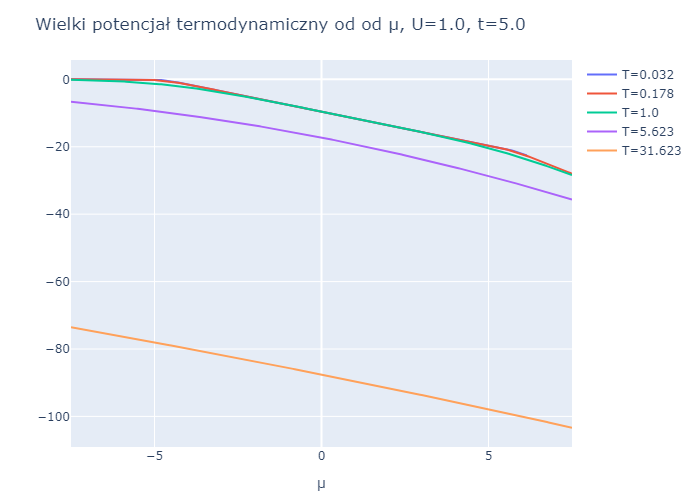

In [22]:
y_vals = grand_pots

layout = Layout(
    title="Wielki potencjał termodynamiczny od od μ, U=$U, t=$t",
    xaxis_title="μ",
    yaxis_title="",
)
plot([scatter(x=chem_potentials, y=yval, name="T=$t") for (yval, t) in zip(y_vals, temp_range)], layout)

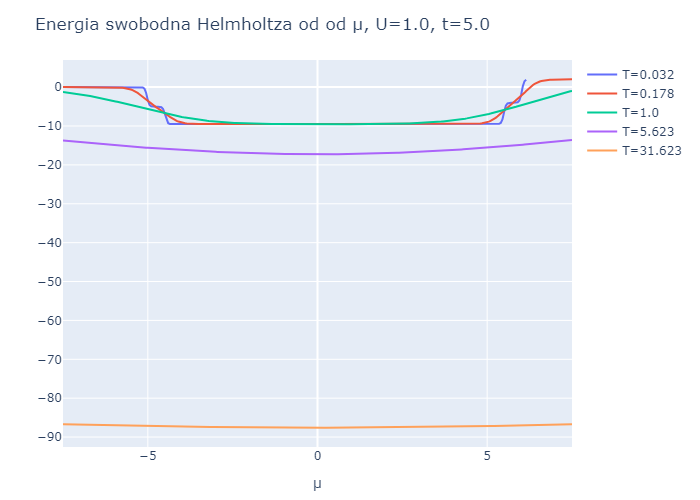

In [23]:
y_vals = real.(helmholtz_vals)

layout = Layout(
    title="Energia swobodna Helmholtza od od μ, U=$U, t=$t",
    xaxis_title="μ",
    yaxis_title="",
)
plot([scatter(x=chem_potentials, y=yval, name="T=$t") for (yval, t) in zip(y_vals, temp_range)], layout)

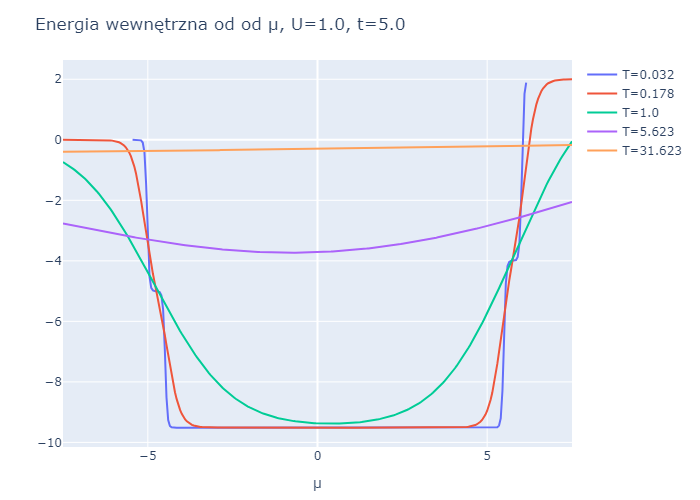

In [24]:
y_vals = U_vals

layout = Layout(
    title="Energia wewnętrzna od od μ, U=$U, t=$t",
    xaxis_title="μ",
    yaxis_title="",
)
plot([scatter(x=chem_potentials, y=yval, name="T=$t") for (yval, t) in zip(y_vals, temp_range)], layout)